In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
nx=9
ny=6
Adress_of_camera_cal="./camera_cal/"
list_of_camera_cal=os.listdir(Adress_of_camera_cal)

Adress_of_test_images="./test_images/"
list_of_test_images=os.listdir(Adress_of_test_images)


To calculate camera calibration for Images that are stored in the folder called camera_cal, I compute the camera matrix and distortion co-efficients to undistort the image.

In [9]:
def calibration_calculate(Adress,list_photos,nx,ny):
    objpoints=[]
    imgpoints=[]
    obj=np.zeros((nx*ny,3),np.float32)
    obj[:,:2]=np.mgrid[:nx,:ny].T.reshape(-1,2)
    for i in list_photos:
        img=mpimg.imread(Adress+i)
        gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret,corners=cv2.findChessboardCorners(gray,(nx,ny),None)
        if (ret==True):
            imgpoints.append(corners)
            objpoints.append(obj)
            cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
            #plt.imshow(img)
            #plt.pause(3)
    return imgpoints,objpoints

In [10]:
def cal_distortion(img,objpoints,imgpoints):
    ret,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(objpoints,imgpoints,img.shape[1::-1],None,None)
    return mtx,dist  

In [11]:
def undistortion(img,mtx,dist):
    undist=cv2.undistort(img,mtx,dist,None,mtx)
    return undist

In [12]:
def corners_unwarp(img,nx,ny,mtx,dist):
    #undistort images
    undist=undistortion(img,mtx,dist)
    #convert to gray
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret,corners=cv2.findChessboardCorners(gray,(nx,ny),None)
    if (ret==True):
        img2=cv2.drawChessboardCorners(undist,(nx,ny),corners,ret)
        #define 4 source points src = np.float32([[,],[,],[,],[,]])
        src=np.array([corners[0],corners[nx-1],corners[ny*nx-nx],corners[ny*nx-1]])

        h,w = img.shape[:2]
        #define 4 Distination points src = np.float32([[,],[,],[,],[,]])
        dst = np.float32([[100,100],[w-100,100],[100,h-100],[w-100,h-100]])
        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        #cv2.warpPerspective() to warp your image to a top-down view
        warped=cv2.warpPerspective(img2,M,(w,h),flags=cv2.INTER_LINEAR)
    return warped,undist
        

In [13]:
imgpoints,objpoints=calibration_calculate(Adress_of_camera_cal,list_of_camera_cal,nx,ny)

In [14]:
img=mpimg.imread(Adress_of_camera_cal+list_of_camera_cal[4])
mtx,dist =cal_distortion(img,objpoints,imgpoints)
warped,undist=corners_unwarp(img,nx,ny,mtx,dist)

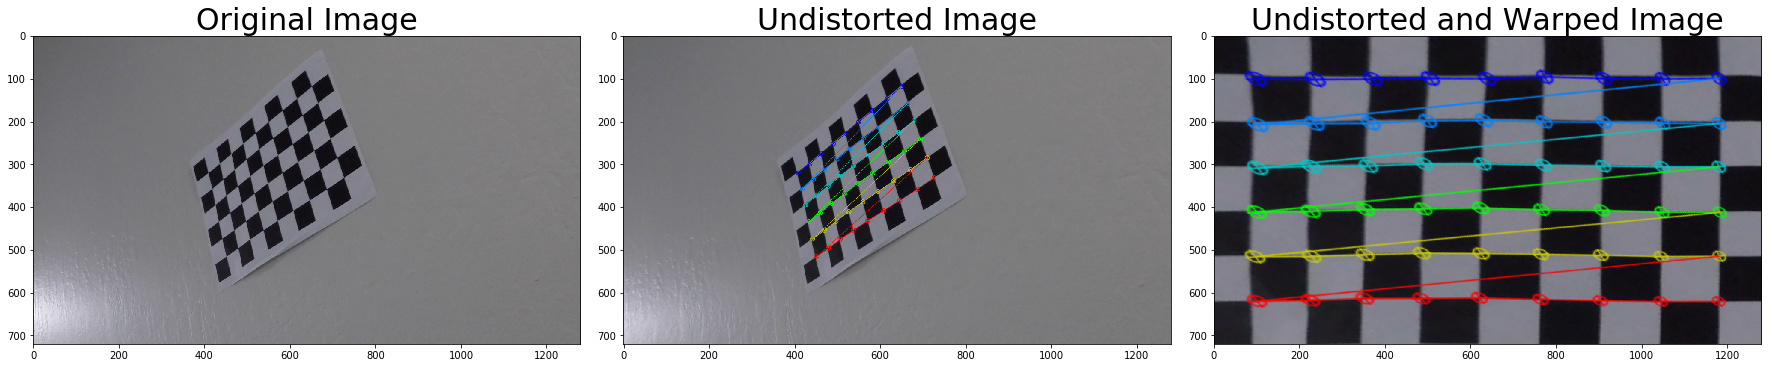

In [15]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 19))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
ax3.imshow(warped)
ax3.set_title('Undistorted and Warped Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("./output_images/1.png")

# Gradients and color thresholds.

I applied thresholds on X, Y and direction und magnitude gradients and combined them with Gradient of color channel H from HLS color spaces to obtain a binary thresholded image.

In [16]:
def abs_sobel_thresh(image,orient='x',thresh=(40,250) ,sobel_kernel=3):
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize= sobel_kernel)
    if (orient=='y'):
        sobel=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize= sobel_kernel)
    abs_sobel=np.absolute(sobel)
    scaled_sobel=(255*abs_sobel/np.max(abs_sobel))
    grad_binary=np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel>=thresh[0])&(scaled_sobel<=thresh[1])]=1
    return grad_binary



def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)

    gradmag=np.sqrt(sobelx**2+sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag=np.uint8(gradmag/scale_factor )
    mag_binary=np.zeros_like(gradmag)
    mag_binary[(gradmag>=mag_thresh[0])&(gradmag<=mag_thresh[1])]=1
    # Apply threshold
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    abs_sobelx=np.absolute(sobelx)
    abs_sobely=np.absolute(sobely)
    abs_graddir=np.arctan(abs_sobely,abs_sobelx)
    dir_binary=np.zeros_like(abs_graddir)
    dir_binary[(abs_graddir>=thresh[0])&(abs_graddir<=thresh[1])]=1
    # Calculate gradient direction
    # Apply threshold
    return dir_binary
def combined_thresholds(gradx,grady,mag_binary,dir_binary):
    combined=np.zeros_like(dir_binary)
    combined[(gradx==1)&(grady==1 )| (mag_binary==1)&(dir_binary==1)]=1
    return combined
    

def HLScolor(image, s_thresh=(170, 255)):
    img=np.copy(image)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    color_binary=np.zeros_like(s_channel)
    color_binary[(s_channel>=s_thresh[0])&(s_channel<=s_thresh[1])]=1
    

    return color_binary


def LUVcolor(image, thresh=(150, 200)):
    img=np.copy(image)
    # Convert to HLS color space and separate the L channel
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    l_channel = luv[:,:,0]
    #u_channel = luv[:,:,1]
    #v_channel = luv[:,:,2]
    color_binary=np.zeros_like(l_channel)
    color_binary[(l_channel>=thresh[0])&(l_channel<=thresh[1])]=1
    return color_binary

def LABcolor(image, thresh=(150, 200)):
    img=np.copy(image)
    # Convert to HLS color space and separate the L channel
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    b_channel = lab[:,:,2]
    color_binary=np.zeros_like(b_channel)
    color_binary[(b_channel>=thresh[0])&(b_channel<=thresh[1])]=1
    return color_binary
def RGBcolor(image, thresh=(150, 200)):
    img=np.copy(image)
    #separate the R channel from RGB color space
    R_channel = img[:,:,0]
    color_binary=np.zeros_like(R_channel)
    color_binary[(R_channel>=thresh[0])&(R_channel<=thresh[1])]=1
    return color_binary

def combined_thresholds_color(combined_gradient,color_binary):
    combined_thresholds_color=np.zeros_like(combined_gradient)
    combined_thresholds_color[(combined_gradient==1)|(color_binary==1)]=1
    return combined_thresholds_color
    

In [17]:
list_of_test_images[2]#2 #0 #5

'test1.jpg'

In [18]:
img1=mpimg.imread(Adress_of_test_images+list_of_test_images[4])
img_undist =undistortion(img1,mtx,dist)
gradx=abs_sobel_thresh(img_undist,orient='x',thresh=(20,100) ,sobel_kernel=5)
grady=abs_sobel_thresh(img_undist,orient='y',thresh=(20,100) ,sobel_kernel=5)
mag_binary=mag_thresh(img_undist, sobel_kernel=3, mag_thresh=(50, 200))
dir_binary=dir_threshold(img_undist, sobel_kernel=3, thresh=(.7, 1.4))
combined_gradient=combined_thresholds(gradx,grady,mag_binary,dir_binary)

HLScolor_binary=HLScolor(img_undist, s_thresh= (150, 200))
combined_thresholds_color1=combined_thresholds_color(combined_gradient,HLScolor_binary)

LUVcolor_binary=LUVcolor(img_undist, thresh= (150, 255))
combined_thresholds_color2=combined_thresholds_color(combined_thresholds_color1,LUVcolor_binary)



LABcolor_binary=LUVcolor(img_undist, thresh= (150, 215))
combined_thresholds_color3=combined_thresholds_color(combined_thresholds_color2,LABcolor_binary)

RGBcolor_binary=RGBcolor(img_undist, thresh= (150, 220))
combined_thresholds_color4=combined_thresholds_color(combined_thresholds_color3,RGBcolor_binary)



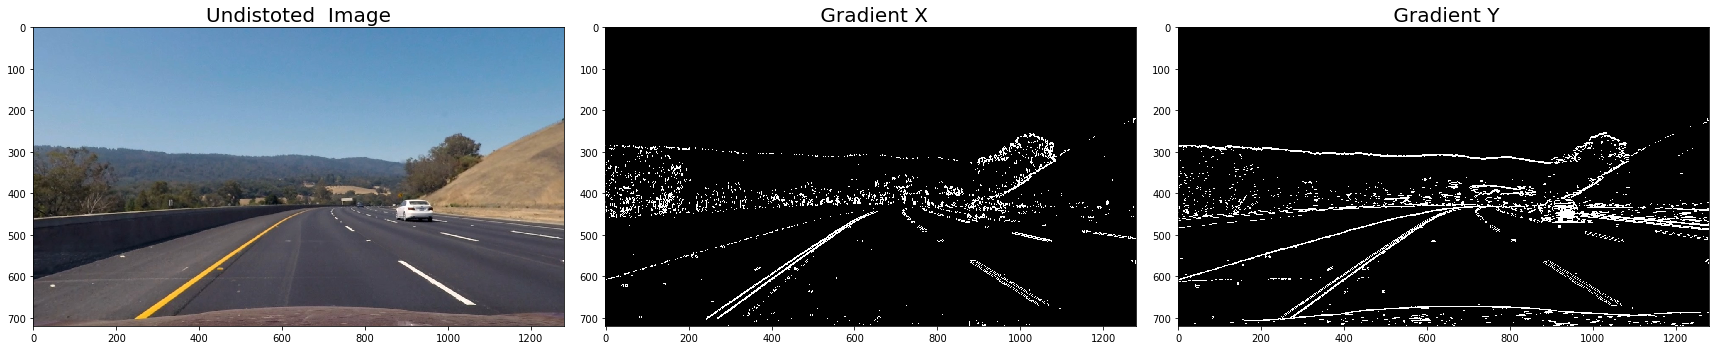

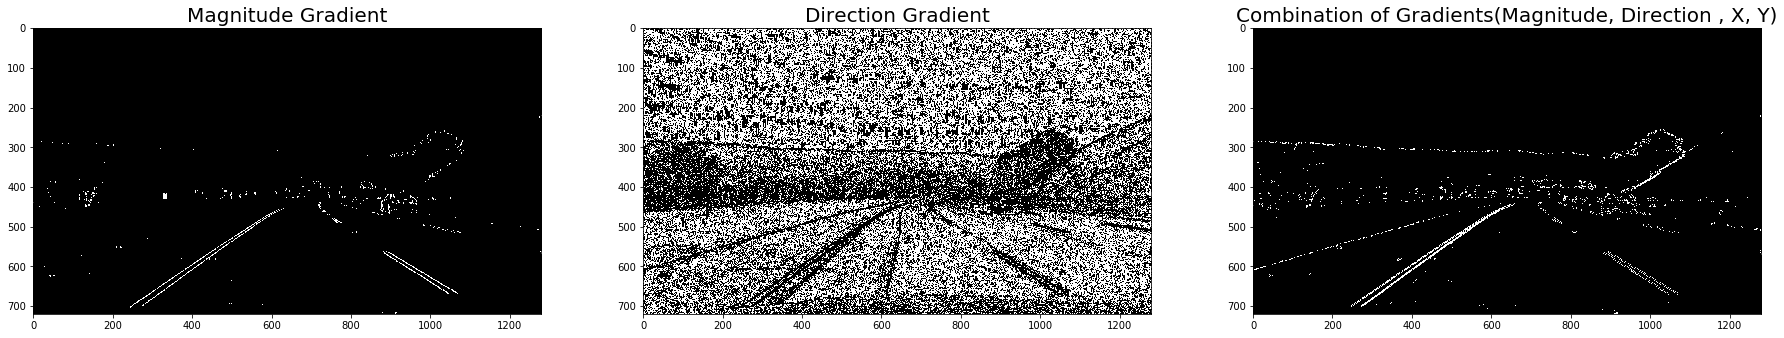

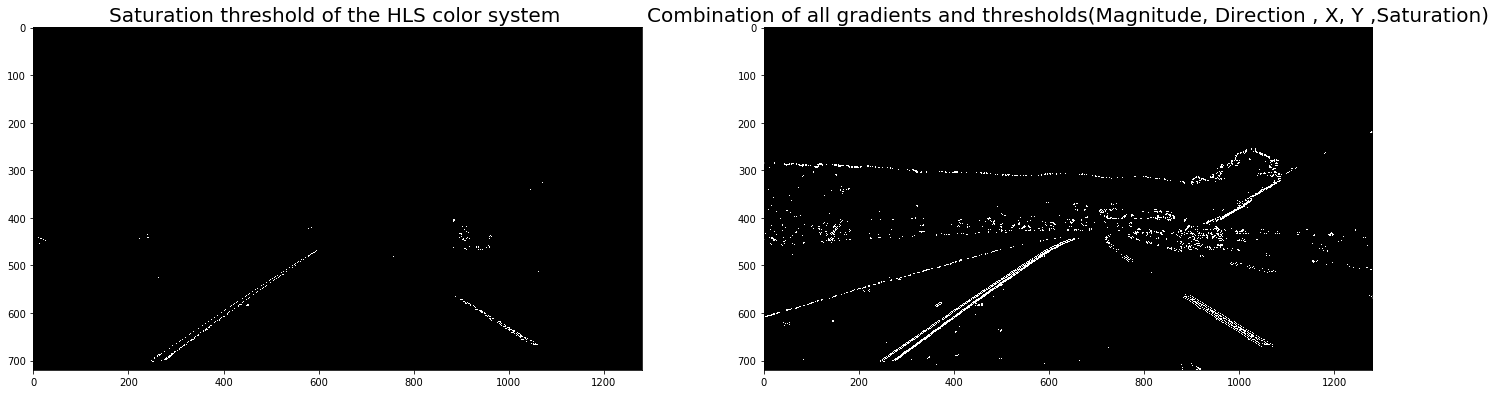

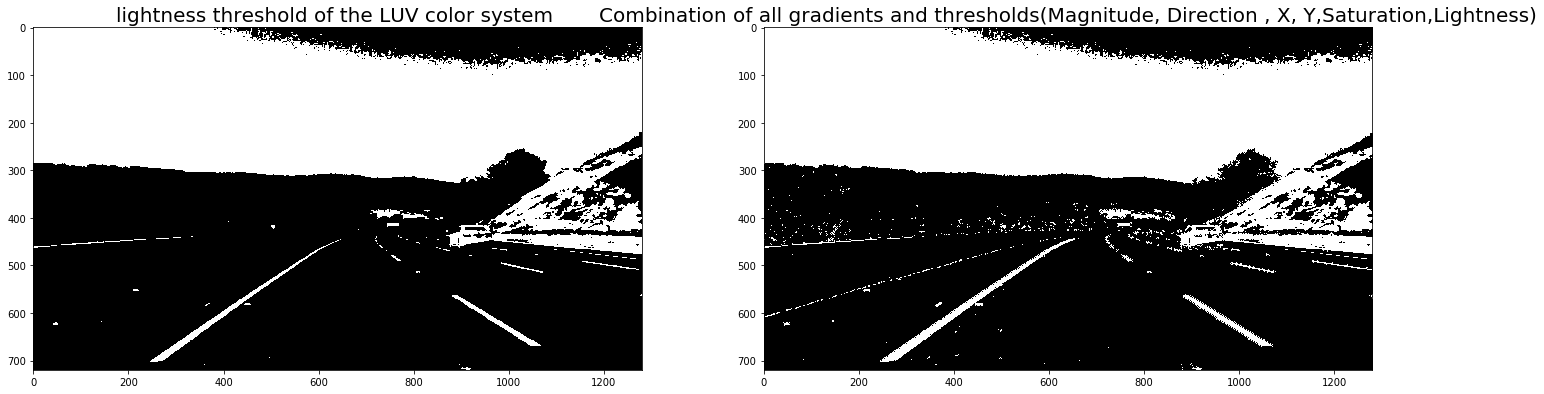

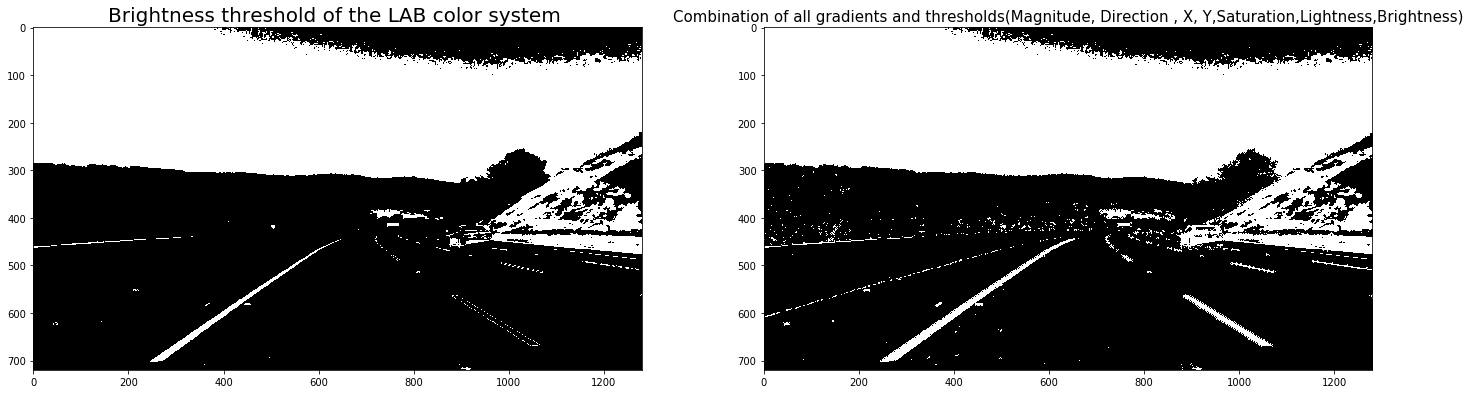

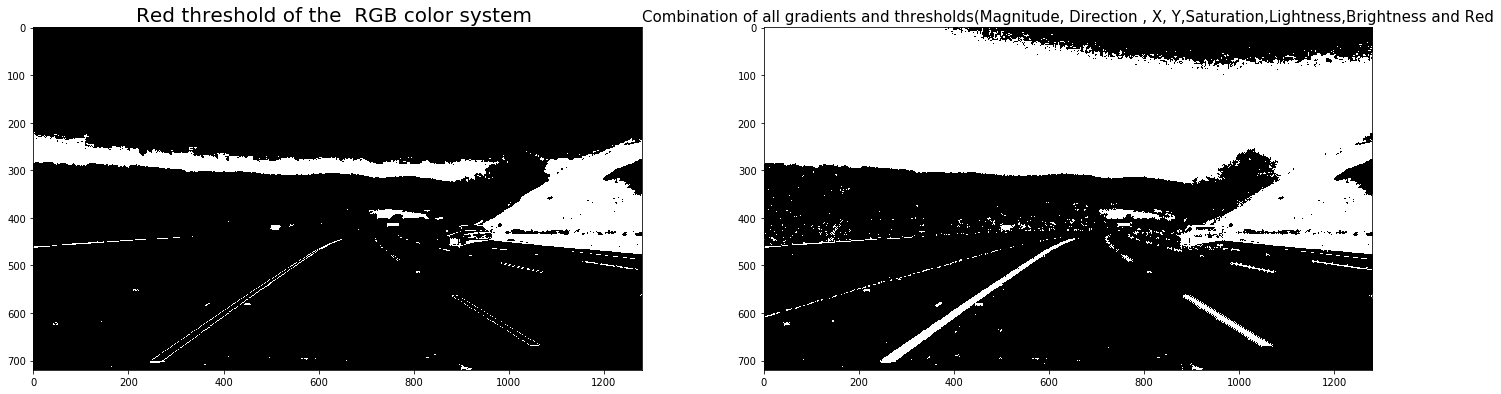

In [19]:
# Plot the result
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 19))
f.tight_layout()
ax1.imshow(img_undist)
ax1.set_title('Undistoted  Image', fontsize=20)
ax2.imshow(gradx, cmap='gray')
ax2.set_title(' Gradient X', fontsize=20)
ax3.imshow(grady, cmap='gray')
ax3.set_title(' Gradient Y', fontsize=20)
f.savefig("./output_images/2.png")


f, (ax4,ax5,ax6) = plt.subplots(1, 3, figsize=(24, 19))

ax4.set_title('Magnitude Gradient', fontsize=20)
ax4.imshow(mag_binary, cmap='gray')
ax5.set_title('Direction Gradient', fontsize=20)
ax5.imshow(dir_binary, cmap='gray')
ax6.set_title('Combination of Gradients(Magnitude, Direction , X, Y)', fontsize=20)
ax6.imshow(combined_gradient, cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig("./output_images/3.png")

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 19))

ax1.set_title('Saturation threshold of the HLS color system ', fontsize=20)
ax1.imshow(HLScolor_binary, cmap='gray')
ax2.set_title('Combination of all gradients and thresholds(Magnitude, Direction , X, Y ,Saturation)', fontsize=20)
ax2.imshow(combined_thresholds_color1, cmap='gray')
f.savefig("./output_images/4.png")

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 19))

ax1.set_title('lightness threshold of the LUV color system ', fontsize=20)
ax1.imshow(LUVcolor_binary, cmap='gray')
ax2.set_title('Combination of all gradients and thresholds(Magnitude, Direction , X, Y,Saturation,Lightness)', fontsize=20)
ax2.imshow(combined_thresholds_color2,cmap='gray')
f.savefig("./output_images/5.png")


f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 19))

ax1.set_title('Brightness threshold of the LAB color system ', fontsize=20)
ax1.imshow(LABcolor_binary, cmap='gray')
ax2.set_title('Combination of all gradients and thresholds(Magnitude, Direction , X, Y,Saturation,Lightness,Brightness)', fontsize=15)
ax2.imshow(combined_thresholds_color3,cmap='gray')
f.savefig("./output_images/6.png")

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 19))

ax1.set_title('Red threshold of the  RGB color system ', fontsize=20)
ax1.imshow(RGBcolor_binary, cmap='gray')
ax2.set_title('Combination of all gradients and thresholds(Magnitude, Direction , X, Y,Saturation,Lightness,Brightness and Red' , fontsize=15)
ax2.imshow(combined_thresholds_color4,cmap='gray')
f.savefig("./output_images/7.png")


# fine tuning 
Here is a code to build a widget for parameters fine tuning

In [20]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import  display

def interactive_mask(ksize,x_low,x_high,y_low,y_high,mag_low,mag_high,dir_low,dir_high,hls_low,hls_high
                     ,luv_low,luv_high,lab_low,lab_high,rgb_low,rgb_high):
    
    gradx=abs_sobel_thresh(img_undist,orient='x',thresh=(x_low,x_high) ,sobel_kernel=ksize)
    grady=abs_sobel_thresh(img_undist,orient='y',thresh=(y_low,y_high) ,sobel_kernel=ksize)
    mag_binary=mag_thresh(img_undist, sobel_kernel=3, mag_thresh=(mag_low,mag_high))
    dir_binary=dir_threshold(img_undist, sobel_kernel=3, thresh=(dir_low,dir_high))
    combined_gradient=combined_thresholds(gradx,grady,mag_binary,dir_binary)

    HLScolor_binary=HLScolor(img_undist, s_thresh= (hls_low,hls_high))
    combined_thresholds_color1=combined_thresholds_color(combined_gradient,HLScolor_binary)

    LUVcolor_binary=LUVcolor(img_undist, thresh= (luv_low,luv_high))
    combined_thresholds_color2=combined_thresholds_color(combined_thresholds_color1,LUVcolor_binary)



    LABcolor_binary=LUVcolor(img_undist, thresh= (lab_low,lab_high))
    combined_thresholds_color3=combined_thresholds_color(combined_thresholds_color2,LABcolor_binary)

    RGBcolor_binary=RGBcolor(img_undist, thresh= (rgb_low,rgb_high))
    combined_thresholds_color4=combined_thresholds_color(combined_thresholds_color3,RGBcolor_binary)

    plt.figure(figsize=(10,10))
    plt.imshow(combined_thresholds_color4,cmap='gray')


In [21]:
interact(interactive_mask,ksize=(1,31,2),x_low=(0,255),x_high=(0,255),y_low=(0,255),y_high=(0,255),\
         mag_low=(0,255),mag_high=(0,255),dir_low=(0,np.pi/2),dir_high=(0,np.pi/2),hls_low=(0,255),hls_high=(0,255),\
         luv_low=(0,255),luv_high=(0,255),lab_low=(0,255),lab_high=(0,255),rgb_low=(0,255),rgb_high=(0,255))

interactive(children=(IntSlider(value=15, description='ksize', max=31, min=1, step=2), IntSlider(value=127, de…

<function __main__.interactive_mask>

# Perspective transform ("birds-eye view") 

First, I extracted the source and distinction points to perform a perspective transformation. Then I feed the binary threshold image from the last step into the transform_image(img) function to get a bird's eye view from above.


In [22]:
def transform_image(img):
    

    img_size=(img.shape[0],img.shape[1])
    src, dst=calc_warp_points(img_size)

    M_inv = cv2.getPerspectiveTransform(dst, src)

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img.shape[::-1], flags=cv2.INTER_NEAREST)
    return warped,M_inv
    
    

In [23]:
def calc_warp_points(img_size):
    
    # Here you can see the defined vertices for the "region of interest"
        
    '''    leftupperpoint  = [568,470]
    rightupperpoint = [717,470]
    leftlowerpoint  = [260,680]
    rightlowerpoint = [1043,680]

    src = np.float32([leftupperpoint, leftlowerpoint, rightupperpoint, rightlowerpoint])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])

    '''
     
    height=img_size[0]
    width=img_size[1]

    s1 = [width // 2 - 76, height * 0.625]
    s2 = [width // 2 + 76, height * 0.625]
    s3 = [-100, height]
    s4 = [width + 100, height]
    src = np.float32([s1, s2, s3, s4])
    # Vertices coordinates in the destination image
    d1 = [100, 0]
    d2 = [width - 100, 0]
    d3 = [100, height]
    d4 = [width - 100, height]
    dst = np.float32([d1, d2, d3, d4])

    return src, dst

Here I added morphological dilation and erosion to make the edge lines continuous:

In [27]:
def closing(warped):
    guassian=cv2.GaussianBlur(warped,(3,3),0)
    kernel = np.ones((7, 7), np.uint8)
    closing = cv2.morphologyEx(guassian.astype(np.uint8), cv2.MORPH_CLOSE, kernel,2)
    return closing

In [28]:
warped,M_inv=transform_image(combined_thresholds_color4)
closing_warped_img=closing(warped)

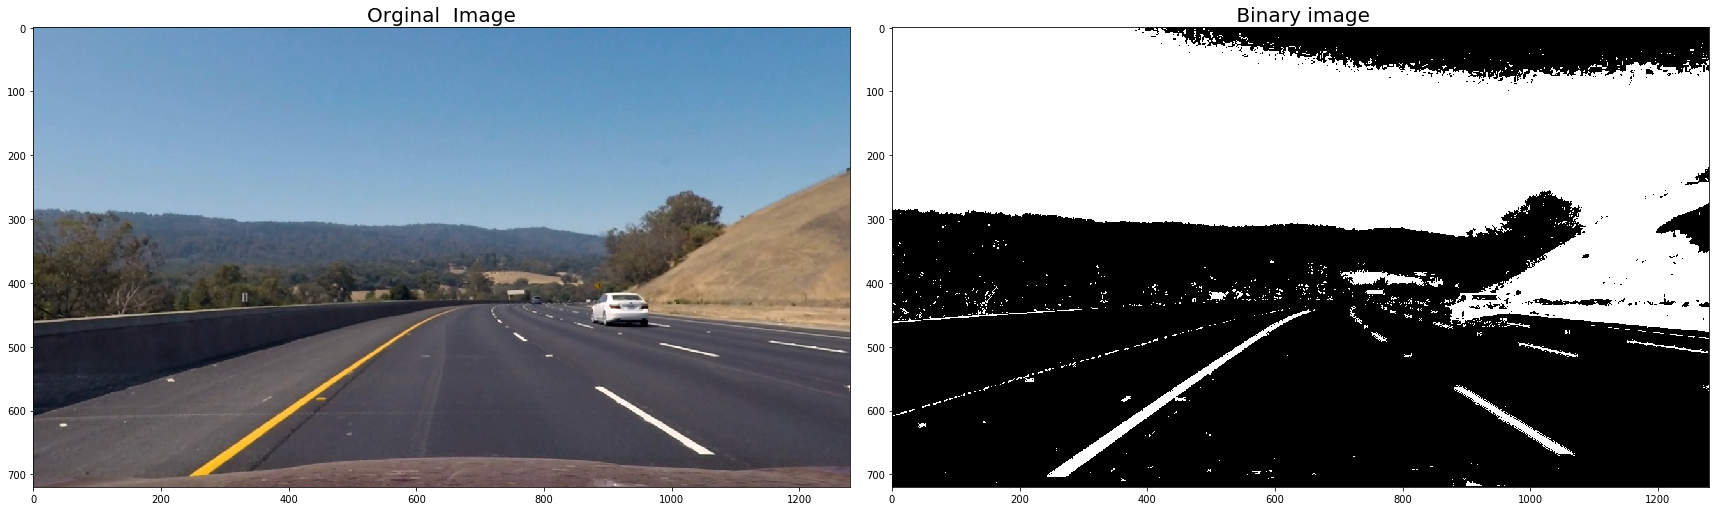

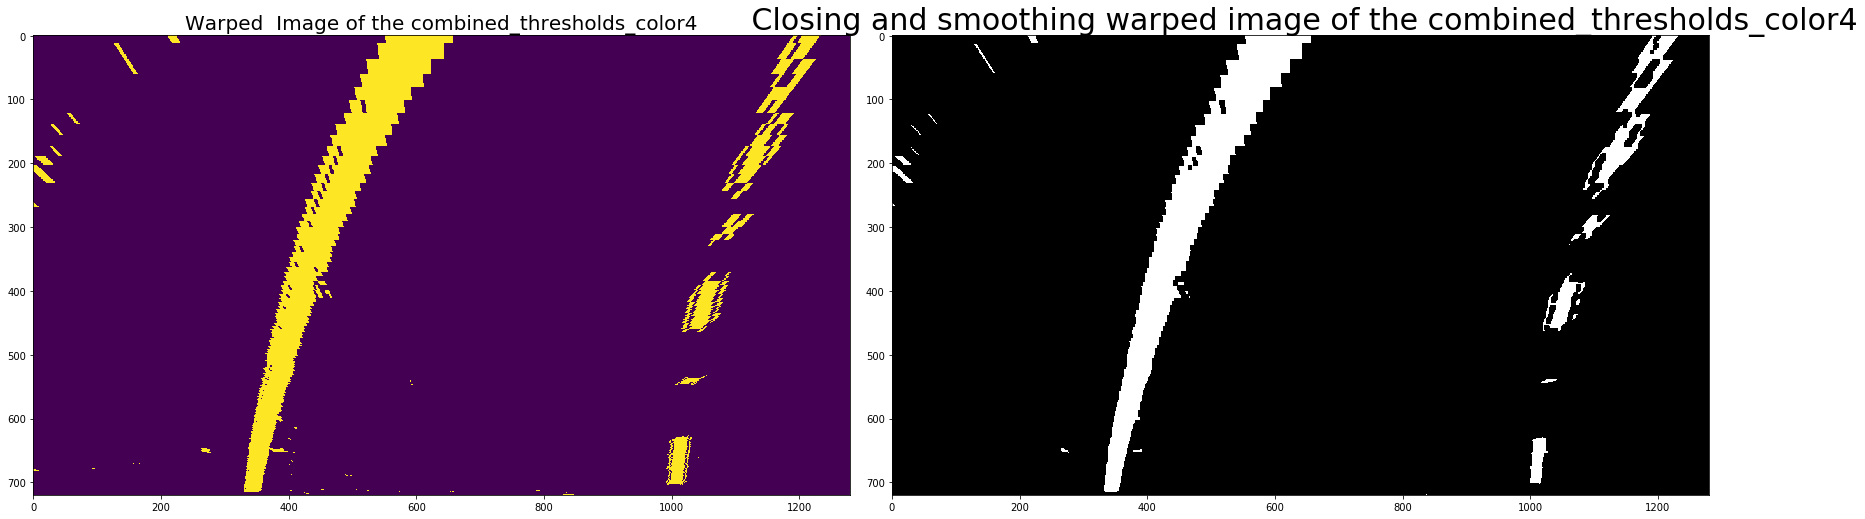

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 19))
f.tight_layout()
ax1.imshow(img_undist)
ax1.set_title('Orginal  Image', fontsize=20)
ax2.imshow(combined_thresholds_color4, cmap='gray')
ax2.set_title(' Binary image', fontsize=20)
f.savefig("./output_images/8.png")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 19))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('Warped  Image of the combined_thresholds_color4', fontsize=20)
ax2.imshow(closing_warped_img, cmap='gray')
ax2.set_title(' Closing and smoothing warped image of the combined_thresholds_color4',fontsize=30)
f.savefig("./output_images/9.png")


# Noise Detection

In [20]:
def noise_detect(warped):
    histogram=np.sum(warped, axis = 1)
    return (histogram > 150).any()

In [21]:
print(noise_detect(closing_warped_img))
if (noise_detect(closing_warped_img)):
    warped,M_inv=transform_image(combined_thresholds_color1)
    closing_warped_img=closing(warped)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 19))
    f.tight_layout()
    ax1.imshow(warped)
    ax1.set_title('Warped  Image of the combined_thresholds_color1', fontsize=20)
    ax2.imshow(closing_warped_img, cmap='gray')
    ax2.set_title('Closing and smoothing warped image of the combined_thresholds_color1', fontsize=20)

    

False


# Implement Sliding Windows and Fit a Polynomial

On this level I perform a sliding window search, startingwith the base likely positions of the 2 lane (shown in the first image), calculated from the histogram. I used 9 windows with a width of 100 pixels. The x & y coordinates of non-zero pixels are found, a polynomial is adjusted for these coordinates and the track lines are drawn.

In [22]:
def detect_lines(img, return_img=False):
    
    def get_histogram(img):
        return np.sum(img[img.shape[0]//2:, :], axis=0)
    # Take a histogram of the bottom half of the image
    histogram = get_histogram(img)

    if return_img:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((img, img, img))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])   
    nonzeroy = np.array(nonzero[0])
   

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if return_img:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (255,100,0),5)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (255,100,0),5)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if return_img:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Draw left and right lines
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 5, (2,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 5, (2,255,0))
            
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype('float32')

    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

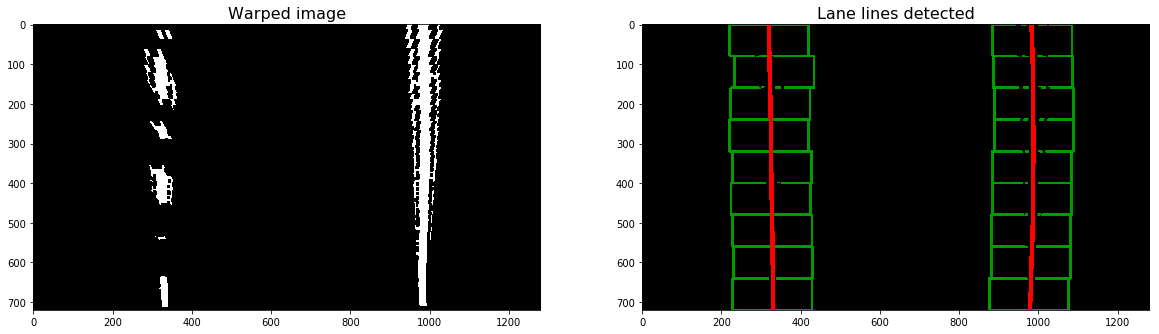

In [23]:
lines_fit, left_points, right_points, out_img = detect_lines(closing_warped_img, return_img=True)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))


ax1.set_title('Warped image', fontsize=16)
ax1.imshow(closing_warped_img, cmap='gray')

ax2.set_title('Lane lines detected', fontsize=16)
ax2.imshow(out_img)


# Finding the Lines: Search from Prior

Searching around previosly detected lane line Since consecutive frames are likely to have lane lines in roughly similar positions, we search around a margin of 100 pixels of the previously detected lane lines.


In [62]:


def detect_similar_lines(img, line_fits=None, return_img=False):
    if line_fits is None:
        return detect_lines(img, return_img)
    
    left_fit = line_fits[0]
    right_fit = line_fits[1]
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If any of the lines could not be found, 
    # perform a more exhaustive search
    if (leftx.size == 0 or rightx.size == 0):
        return detect_lines(img, return_img)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    if return_img:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((img, img, img))*255
        window_img = np.zeros_like(out_img)

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 100, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 255]
     
        for index in range(img.shape[0]):
            cv2.circle(out_img, (int(left_fitx[index]), int(ploty[index])), 3, (0,255,0))
            cv2.circle(out_img, (int(right_fitx[index]), int(ploty[index])), 3, (0,255,0))
    
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img.astype("float32")
    
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)



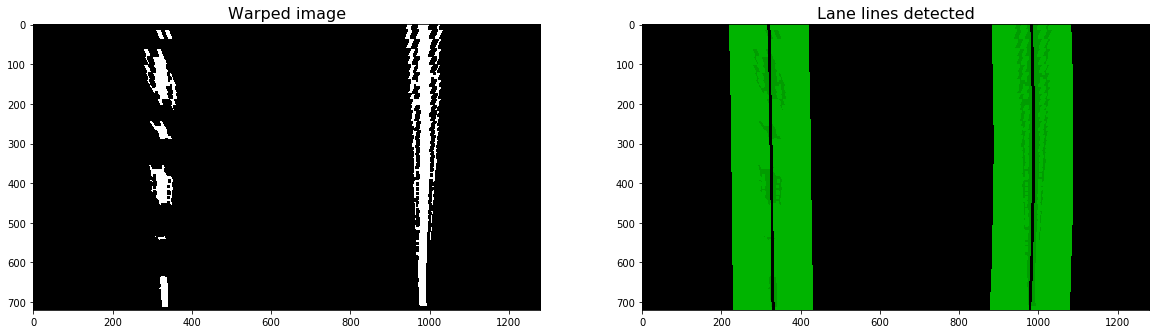

In [63]:
lines_fit, left_points, right_points, out_img = detect_similar_lines(closing_warped_img, lines_fit, return_img=True)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))


ax1.set_title('Warped image', fontsize=16)
ax1.imshow(closing_warped_img, cmap='gray')

ax2.set_title('Lane lines detected', fontsize=16)
ax2.imshow(out_img)


In [64]:
def curvature_radius (leftx, rightx, img_shape, xm_per_pix=3.7/800, ym_per_pix = 25/720):
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    leftx = leftx[::-1] 
    rightx = rightx[::-1] 
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)



In [65]:
# Run the function
curvature_rads = curvature_radius(leftx=left_points[0], rightx=right_points[0], img_shape = img.shape)

# Print the results
print('Left line curvature:', curvature_rads[0], 'm')
print('Right line curvature:', curvature_rads[1], 'm')

Left line curvature: 19271.1144058 m
Right line curvature: 2514.92111133 m


In [66]:
def car_offset(leftx, rightx, img_shape, xm_per_pix=3.7/800):
    ## Image mid horizontal position 
    mid_imgx = img_shape[1]//2
        
    ## Car position with respect to the lane
    car_pos = (leftx[-1] + rightx[-1])/2
    
    ## Horizontal car offset 
    offsetx = (mid_imgx - car_pos) * xm_per_pix

    return offsetx



In [67]:
# Run the function
offsetx = car_offset(leftx=left_points[0], rightx=right_points[0], img_shape=img.shape)

print ('Car offset from center:', offsetx, 'm.')

Car offset from center: -0.0631489416313 m.


In [68]:
def draw_lane(img, warped_img, left_points, right_points, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points[0]
    right_fitx = right_points[0]
    ploty = left_points[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

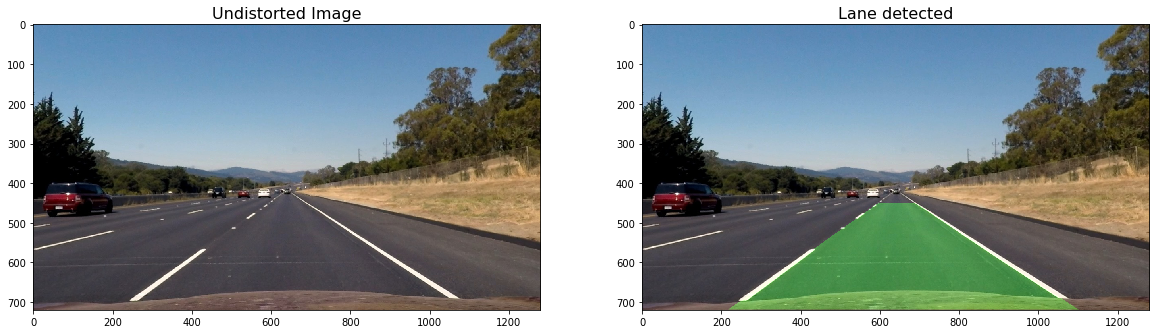

In [69]:
# Run the function
img_lane = draw_lane(img_undist, closing_warped_img, left_points, right_points, M_inv)

# Plot the results


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Undistorted Image', fontsize=16)
ax1.imshow(img_undist)

ax2.set_title('Lane detected', fontsize=16)
ax2.imshow(img_lane, cmap='gray')


In [70]:
def add_metrics(img, leftx, rightx, xm_per_pix=3.7/800, ym_per_pix = 25/720):    
    # Calculate radius of curvature
    curvature_rads = curvature_radius(leftx=leftx, rightx=rightx, img_shape=img.shape,
                                      xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    # Calculate car offset
    offsetx = car_offset(leftx=leftx, rightx=rightx, img_shape=img.shape)

    # Display lane curvature
    out_img = img.copy()
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(curvature_rads[0]), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,255), 5)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(curvature_rads[1]), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,255), 5)
    
    # Display car offset
    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,255), 5)
    
    return out_img

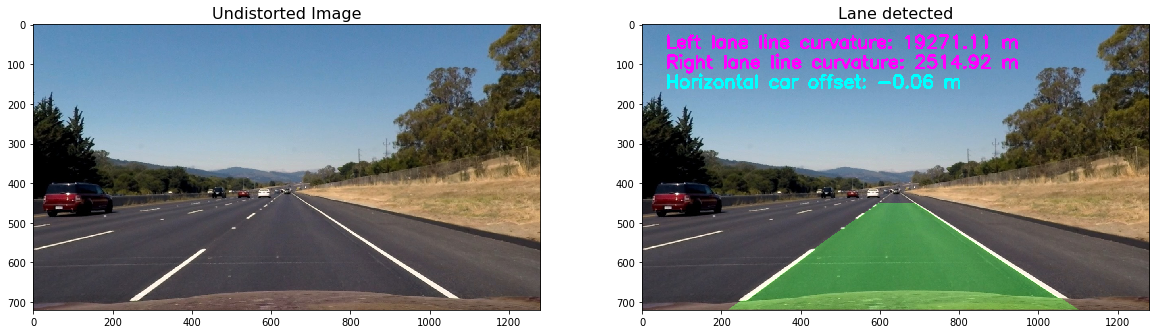

In [71]:
out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Undistorted Image', fontsize=16)
ax1.imshow(img_undist)

ax2.set_title('Lane detected', fontsize=16)
ax2.imshow(out_img, cmap='gray')


# Pipline
The pipeline is applied to videos 

1-undistor image.

2-claculate x gradient.

3-calculate y gradient.

4-calculate direction gradient.

5-calculate magnitude gradient.

6-calculate color threshold of S channel from HLS color space.

7-calculate color threshold of L channel from LUV color space.

8-calculate color threshold of B  channel from LAB color space.


9- combined all gradients and thresholds fom last steps.

10-Feed the threshold binary image to tensform perspectice function to get a bird eye view.

11-add morphological dilation and erosion to make the edge lines continuous

12-perform nois detection function and if the answer of it is True we can take the binary image from combined_thresholds_color1 that has better result in noisy images.

13-perform fit polynomial algorithm.

14-calculate curvatures and car offset.


15-Add calculated curvatures and car offset with Lane detected image.



In [74]:

class ProcessImage:
    def __init__(self):
        self.lines_fit = None

    def __call__(self, img):       

        img_undist =undistortion(img,mtx,dist)
        gradx=abs_sobel_thresh(img_undist,orient='x',thresh=(20,150) ,sobel_kernel=3)
        grady=abs_sobel_thresh(img_undist,orient='y',thresh=(20,150) ,sobel_kernel=3)
        mag_binary=mag_thresh(img_undist, sobel_kernel=3, mag_thresh=(30, 150))
        dir_binary=dir_threshold(img_undist, sobel_kernel=3, thresh=(.7, 1.4))
        combined_gradient=combined_thresholds(gradx,grady,mag_binary,dir_binary)

        HLScolor_binary=HLScolor(img_undist, s_thresh= (150, 255))
        combined_thresholds_color1=combined_thresholds_color(combined_gradient,HLScolor_binary)

        LUVcolor_binary=LUVcolor(img_undist, thresh= (150, 255))
        combined_thresholds_color2=combined_thresholds_color(combined_thresholds_color1,LUVcolor_binary)

        LABcolor_binary=LUVcolor(img_undist, thresh= (150, 215))
        combined_thresholds_color3=combined_thresholds_color(combined_thresholds_color2,LABcolor_binary)


        RGBcolor_binary=RGBcolor(img_undist, thresh= (150, 220))
        combined_thresholds_color4=combined_thresholds_color(combined_thresholds_color3,RGBcolor_binary)

        warped, M_inv=transform_image(combined_thresholds_color4)
        closing_warped_img=closing(warped)
        combined_threshold=combined_thresholds_color4

        if (noise_detect(closing_warped_img)):
            warped,M_inv=transform_image(combined_thresholds_color1)
            closing_warped_img=closing(warped)
            combined_threshold=combined_thresholds_color1  
        self.lines_fit, left_points, right_points,out_img0 = detect_similar_lines(closing_warped_img, self.lines_fit, return_img=True)            # Warp the detected lane boundaries back onto the original image.
        resized_poly=cv2.resize(out_img0,(640,240),cv2.INTER_AREA)
        
        img_lane = draw_lane(img_undist, closing_warped_img, left_points, right_points, M_inv)
            
        # Add metrics to the output img
        out_img = add_metrics(img_lane, leftx=left_points[0], rightx=right_points[0])     

        resized_combined_threshold=cv2.resize(combined_threshold,(640,240),cv2.INTER_AREA)
        resized_combined_threshold=np.dstack((resized_combined_threshold,resized_combined_threshold,resized_combined_threshold)) *255

        resized_warped=cv2.resize(closing_warped_img,(640,240),cv2.INTER_AREA)
        resized_warped=np.dstack((resized_warped,resized_warped,resized_warped)) *255
        vis = np.zeros((720, 1280+640, 3))

        vis[:720, :1280,:] = out_img
        vis[:240, 1280:1920,:] = resized_combined_threshold
        vis[240:480, 1280:1920,:] =resized_warped
        vis[480:720, 1280:1920,:] =resized_poly

        return vis
            
 

In [75]:


white_output = './output_images/1.mp4'

processImage=ProcessImage()
clip1 = VideoFileClip("./project_video.mp4")#.subclip(22,24)

white_clip= clip1.fl_image(processImage)
%time white_clip.write_videofile(white_output, audio=False)



[MoviePy] >>>> Building video ./output_images/1.mp4
[MoviePy] Writing video ./output_images/1.mp4


100%|█████████▉| 1260/1261 [08:21<00:00,  2.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/1.mp4 

CPU times: user 5min 24s, sys: 2.62 s, total: 5min 27s
Wall time: 8min 25s


## The first and second algorithm is applied on the project_video.mp4 video. 

In [76]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format('./output_images/1.mp4'))